# 値動きのみでFXに勝てるかDeepLeaningに推測させる

## 概要

DeepLearningを使って、過去の値動きから次の瞬間の価格を予測している記事はよく見かける

しかし、一時的な価格だけ予測できたところでトレードで勝つことはできない

必要なのは、特定の期間内においてどういった値動きをして、最終的にどのくらい上がる（もしくは下がる）のかを知ることである

では「特定の期間」とはどのくらいの期間を指すのか？

それはトレードを行う人の性格やトレードスタイル、戦略等によって変わるため、現状明確な正解はないと思われる

本来は、利益を最大化させることのできるトレード期間も合わせて学習できれば良いが、計算量が跳ね上がる上、本当に正解があるかどうかも分からないため、ここではそういった議論は行わない

そこで今回は、以下のようなトレード戦略を採用することにする

- チャートは1分足を採用（足が長くなるほど経済的な影響を受けやすくなると考えたため）
- スプレッドは考慮しない
- 「買い」を入れるタイミングで過去20期間分（20分間分）のATRを算出
    - 算出したATR値を`atr1`とする
    - 「買い」を入れたタイミングでの価格を`price1`とする
- 利確価格を`price1 + 5*atr1`, 損切価格を`price1 - 3*atr1`とする
- 以降、1分ごとに次の方法で手仕舞いを行う
    - 価格が利確価格以上になったら利確する
    - 価格が損切価格以下になったら損切する
    - 価格が`price1 + atr1`以上になったら、利確・損切価格を上にずらす（トレーリングストップ）
        - 新しい利確価格：`その1分足の終値 + 5*atr1`
        - 新しい損切価格：`その1分足の終値 - 3*atr1`

以上のトレード戦略をとった場合、どのようなタイミングで「買い」を入れれば勝てるのかを予測する

## チャートデータ

- チャートデータはTickStoryで取得
- 通貨ペアはUSD/JOY
- 過去5年分の1分足データを学習対象とする

## 環境

- CPU: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz
- Memory: 16GB DDR2
- GPU: NVIDIA GeForce GTX 1070
- Python 3.5
    - DeepLearningライブラリとして Keras（バックグラウンド: TensorFlow）採用

### チャートデータ読み込み

In [1]:
import pandas as pd
import talib

# データフレームを読み込む
df = pd.read_csv('USDJPY_1M_Pretty.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
# ATR20計算
df['ATR'] = talib.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=20)
del df['Volume']
df = df.dropna(how='any') # NaN行の削除
df.head()

,Open,High,Low,Close,ATR
Date,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031


### トレード戦略に沿ってトレードした場合の結果を計算

概要で定めたトレード戦略に沿って、毎分「買い」を入れた場合のトレード結果を計算する

今回はついでに、毎分「売り」を入れた場合についても同様に計算している

In [6]:
import numpy as np
from numba import jit
import time

# TrailingStop
@jit
def buy_trail(data, index, price, atr):
    # TrailingStop: TP=ATR*5, SL=3*ATR, TS=ATR
    tp, sl, ts = price + 5 * atr, price - 3 * atr, price + atr
    for i in range(index, len(data)):
        row = data[i + 1]
        if row[2] <= tp <= row[1]: return tp
        elif row[2] <= sl <= row[1]: return sl
        elif row[2] <= ts <= row[1]: # Move TakeProfit & StopLoss
            tp, sl, ts = row[3] + 5 * atr, row[3] - 3 * atr, row[3] + atr
    return data[-1][3]

@jit
def sell_trail(data, index, price, atr):
    # TrailingStop: TP=ATR*5, SL=3*ATR, TS=ATR
    tp, sl, ts = price - 5 * atr, price + 3 * atr, price - atr
    for i in range(index, len(data)):
        row = data[i + 1]
        if row[2] <= tp <= row[1]: return tp
        elif row[2] <= sl <= row[1]: return sl
        elif row[2] <= ts <= row[1]: # Move TakeProfit & StopLoss
            tp, sl, ts = row[3] - 5 * atr, row[3] + 3 * atr, row[3] - atr
    return data[-1][3]

# Buy & TrailingStop
@jit
def buy(data):
    result = []
    for i in range(len(data)):
        # i番目の瞬間に買いを入れると仮定
        row = data[i]
        result.append(buy_trail(data, i, row[3], row[4]) - row[3]) # 買いを入れた結果（損益）を保存
    return result

# Sell & TrailingStop
@jit
def sell(data):
    result = []
    for i in range(len(data)):
        # i番目の瞬間に売りを入れると仮定
        row = data[i]
        result.append(sell_trail(data, i, row[3], row[4]) - row[3]) # 売りを入れた結果（損益）を保存
    return result

start = time.time()
buy_profit = np.array(buy(df.values))
print("Elapsed Time: {0} sec\nBuyProfits: {1}".format(time.time() - start, buy_profit))

start = time.time()
sell_profit = np.array(sell(df.values))
print("Elapsed Time: {0} sec\nSellProfits: {1}".format(time.time() - start, sell_profit))

Elapsed Time: 1.4574449062347412 sec
BuyProfits: [-0.0162   -0.01474  -0.033853 ... -0.039    -0.031     0.      ]
Elapsed Time: 1.6470015048980713 sec
SellProfits: [ 0.0342    0.03074   0.032853 ... -0.039    -0.031     0.      ]


In [7]:
# numpyデータをcsv化
val = df.values
size = val.shape[0]
data = np.zeros((size, 7))
for i in range(size):
    for x in range(5): data[i][x] = val[i][x]
    data[i][5] = buy_profit[i]
    data[i][6] = sell_profit[i]
csv = pd.DataFrame(index=df.index[:size], columns=['Open', 'High', 'Low', 'Close', 'ATR', 'Buy', 'Sell'], data=data)
csv.to_csv("USDJPY_TrailingStop.csv")
csv.head()

,Open,High,Low,Close,ATR,Buy,Sell
Date,,,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400,-0.016200,0.034200
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580,-0.014740,0.030740
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951,-0.033853,0.032853
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453,-0.036360,0.027360
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031,-0.023092,0.019092


### 目的変数の設定

当初、目的変数は単純にトレード結果の価格（いくら儲かり、いくら損したか）にすれば良いと思っていたが、これではうまく学習できなかった

そのため、トレード結果を以下の4つに分類することにした

1. 大きく勝った（`5*atr1`以上の利益）
2. 勝った（`0`以上の利益）
3. 負けた（`0`未満の利益）
4. 大きく負けた（`-3*atr1`以下の利益）

In [2]:
import numpy as np

# 損益額を4パターン（2: 5*ATRより大きい, 1: 0より大きい, -1: 0より小さい, -2: -3*ATRより小さい）にカテゴライズ
df['Buy_cat'] = np.where(5 * df['ATR'] < df['Buy'], 2, np.where(0 < df['Buy'], 1, np.where(df['Buy'] < -3 * df['ATR'], -2, -1)))
df['Sell_cat'] = np.where(5 * df['ATR'] < df['Sell'], 2, np.where(0 < df['Sell'], 1, np.where(df['Sell'] < -3 * df['ATR'], -2, -1)))
df.to_csv('USDJPY_TrailingStop2.csv')
df.head()

,Open,High,Low,Close,ATR,Buy,Sell,Buy_cat,Sell_cat
Date,,,,,,,,,
2014-01-02 07:21:00,105.351,105.368,105.351,105.354,0.017400,-0.016200,0.034200,-1,1
2014-01-02 07:22:00,105.355,105.355,105.355,105.355,0.016580,-0.014740,0.030740,-1,1
2014-01-02 07:23:00,105.355,105.355,105.351,105.351,0.015951,-0.033853,0.032853,-1,1
2014-01-02 07:24:00,105.354,105.355,105.349,105.355,0.015453,-0.036360,0.027360,-1,1
2014-01-02 07:25:00,105.355,105.381,105.354,105.365,0.016031,-0.023092,0.019092,-1,1


### おまけ：相場の大半がレンジ相場であることを確認

ちなみにトレード結果を以下のようにカテゴライズして分散を確認してみると、相場の大半がレンジ相場であることが確認できた

1. 大きな利益
2. 小さな利益
3. 損益なし
4. 小さな損失
5. 大きな損失

In [9]:
''' 損益結果をカテゴライズ '''
# 5つのパターン（0：大きな損失、1：小さな損失、2：損益なし、3：小さな利益、4：大きな利益）

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Ybuy = csv['Buy'].values.reshape(-1, 1)
scaler.fit(Ybuy)
Ybuy = scaler.transform(Ybuy)
Ybuy = np.floor(Ybuy * 5) # 5パターンにカテゴライズ
Ybuy = np.where(Ybuy == 5., 4., Ybuy) # 最大値が5になっているため4に直す
Ybuy

array([[2.],
       [2.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]])

<BarContainer object of 5 artists>

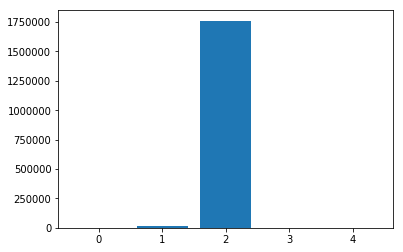

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

Ynum = [len(Ybuy[Ybuy == i]) for i in range(5)]
plt.bar(range(5), Ynum)

### 特徴量と学習モデルの選択

今回は特徴量として、単純に過去60期間分（1時間分）の値動きデータを採用することにした

また、学習モデルとして画像認識によく使われるCNNモデルを選択した

これは、値動きのデータを一つの画像としてパターン学習できるのではないかと考えたからである

ちなみに、数値予測に採用されることの多いLSTMモデルでも学習させてみたが、今回のケースではCNNモデルでの学習と大差なかった

In [1]:
''' CNNモデルで学習させてみる '''

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from numba import jit
from keras.utils.np_utils import to_categorical

# データフレームを読み込む
df = pd.read_csv('USDJPY_TrailingStop2.csv', index_col='Date')
df.index = pd.to_datetime(df.index)
del df['ATR'], df['Open'], df['High'], df['Low'], df['Buy'], df['Sell'], df['Market']
# 特徴量、目的変数
x = df.loc[:, 'Close']
y_buy = df.loc[:, 'Buy_cat']
y_sell = df.loc[:, 'Sell_cat']
# 訓練データ、テストデータに分割
x_train, x_test = x[x.index < '2018'], x[x.index >= '2018']
y_buy_train, y_buy_test = y_buy[y_buy.index < '2018'], y_buy[y_buy.index >= '2018']
y_sell_train, y_sell_test = y_sell[y_sell.index < '2018'], y_sell[y_sell.index >= '2018']

# 特徴量をClose(60)、目的変数をTrailingStop損益結果の4パターンとする
@jit
def gen_xy(x, y_buy, y_sell, window_len=60):
    X, Ybuy, Ysell = [], [], []
    for i in range(len(x) - window_len):
        X.append(x[i : i + window_len].copy())
        Ybuy.append(y_buy[i + window_len - 1])
        Ysell.append(y_sell[i + window_len - 1])
    X, Ybuy, Ysell = np.array(X), np.array(Ybuy), np.array(Ysell)
    # 特徴量を正規化
    scaler = MinMaxScaler()
    scaler.fit(X) # window_len区間の価格の最大値・最小値にフィット
    X = scaler.transform(X)
    # 目的変数を正規化
    Ybuy = np.where(Ybuy > 0, Ybuy + 1, Ybuy + 2)
    Ybuy = to_categorical(Ybuy.astype('int32'))
    Ysell = np.where(Ysell > 0, Ysell + 1, Ysell + 2)
    Ysell = to_categorical(Ysell.astype('int32'))
    return X, Ybuy, Ysell

Xtrain, Ytrain_buy, Ytrain_sell = gen_xy(x_train.values, y_buy_train.values, y_sell_train.values)
x_train.values.shape, x_train.values, Xtrain.shape, Xtrain, y_buy_train.values.shape, y_buy_train.values, Ytrain_buy.shape, Ytrain_buy

Using TensorFlow backend.


((1491718,),
 array([105.354, 105.355, 105.351, ..., 112.671, 112.668, 112.658]),
 (1491658, 60),
 array([[0.23275086, 0.23278836, 0.23263837, ..., 0.23316334, 0.23308835,
         0.23308835],
        [0.23278836, 0.23263837, 0.23278836, ..., 0.23308835, 0.23308835,
         0.23301335],
        [0.23263837, 0.23278836, 0.23316334, ..., 0.23308835, 0.23301335,
         0.23293835],
        ...,
        [0.50682466, 0.50701215, 0.50738713, ..., 0.50727464, 0.50734963,
         0.50719964],
        [0.50701215, 0.50738713, 0.50697465, ..., 0.50734963, 0.50719964,
         0.50712464],
        [0.50738713, 0.50697465, 0.50659967, ..., 0.50719964, 0.50712464,
         0.50701215]]),
 (1491718,),
 array([-1, -1, -1, ..., -1, -1, -1], dtype=int64),
 (1491658, 4),
 array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]], dtype=float32))

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

''' CNNで買い専用AIの訓練 '''

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', padding='valid', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu', padding='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', mode='auto', patience=8)
model_checkpoint = ModelCheckpoint(filepath="BuyerCNN.h5")

# 訓練実行
model.fit(Xtrain.reshape(Xtrain.shape[0], 60, 1), Ytrain_buy,
          batch_size=2048, # 訓練データが多い場合は、ミニバッチサイズを大きくしないとオーバーフローが起きる
          epochs=256,
          shuffle=True,
          validation_split=0.1, # 訓練データのうち10％を検証データとして仕様
          callbacks=[early_stopping, model_checkpoint]
         )

Train on 1342492 samples, validate on 149166 samples
Epoch 1/256
1342492/1342492 [==============================] - 13s 9us/step - loss: 1.2195 - acc: 0.4818 - val_loss: 1.2114 - val_acc: 0.4877
Epoch 2/256
1342492/1342492 [==============================] - 9s 6us/step - loss: 1.2170 - acc: 0.4822 - val_loss: 1.2109 - val_acc: 0.4877
Epoch 3/256
1342492/1342492 [==============================] - 9s 6us/step - loss: 1.2167 - acc: 0.4822 - val_loss: 1.2109 - val_acc: 0.4877
Epoch 4/256
1342492/1342492 [==============================] - 8s 6us/step - loss: 1.2167 - acc: 0.4822 - val_loss: 1.2110 - val_acc: 0.4877
Epoch 5/256
1342492/1342492 [==============================] - 9s 6us/step - loss: 1.2166 - acc: 0.4822 - val_loss: 1.2108 - val_acc: 0.4877
Epoch 6/256
1342492/1342492 [==============================] - 8s 6us/step - loss: 1.2166 - acc: 0.4822 - val_loss: 1.2110 - val_acc: 0.4877
Epoch 7/256
1342492/1342492 [==============================] - 8s 6us/step - loss: 1.2166 - acc: 0.4

In [3]:
Xtest, Ytest_buy, Ytest_sell = gen_xy(x_test.values, y_buy_test.values, y_sell_test.values)
model.evaluate(Xtest.reshape(Xtest.shape[0], 60, 1), Ytest_buy)

285854/285854 [==============================] - 12s 40us/step


[1.2152179759775485, 0.4825855156840822]

上記より、トレード結果を4つにカテゴライズ（大きく勝つ・勝つ・負ける・大きく負ける）する場合、およそ48％の精度で予測できることがわかった

当てずっぽうに4択したら25％の確率であるため、それよりは倍程度良いのだが、個人的にはこの程度の精度でFXに勝つことはできないと考えている（体感的に）

以下、おまけとして、トレード結果を「勝つ・負ける」の2つにカテゴライズした場合についても学習させてみた

In [4]:
''' 目的変数を勝てる・負けるの2パターンにして学習させてみる '''

@jit
def gen_xy(x, y_buy, y_sell, window_len=60):
    X, Ybuy, Ysell = [], [], []
    for i in range(len(x) - window_len):
        X.append(x[i : i + window_len].copy())
        Ybuy.append(y_buy[i + window_len - 1])
        Ysell.append(y_sell[i + window_len - 1])
    X, Ybuy, Ysell = np.array(X), np.array(Ybuy), np.array(Ysell)
    # 特徴量を正規化
    scaler = MinMaxScaler()
    scaler.fit(X) # window_len区間の価格の最大値・最小値にフィット
    X = scaler.transform(X)
    # 目的変数を正規化
    Ybuy = np.where(Ybuy > 0, 1, 0)
    Ybuy = to_categorical(Ybuy.astype('int32'))
    Ysell = np.where(Ysell > 0, 1, 0)
    Ysell = to_categorical(Ysell.astype('int32'))
    return X, Ybuy, Ysell

Xtrain, Ytrain_buy, Ytrain_sell = gen_xy(x_train.values, y_buy_train.values, y_sell_train.values)

model = Sequential()
model.add(Conv1D(32, 3, activation='relu', padding='valid', input_shape=(60, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu', padding='valid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

early_stopping = EarlyStopping(monitor='val_acc', mode='auto', patience=8)
model_checkpoint = ModelCheckpoint(filepath="Buyer2.h5")

# 訓練実行
model.fit(Xtrain.reshape(Xtrain.shape[0], 60, 1), Ytrain_buy,
          batch_size=2048,
          epochs=256,
          shuffle=True,
          validation_split=0.1,
          callbacks=[early_stopping, model_checkpoint]
         )

Train on 1342492 samples, validate on 149166 samples
Epoch 1/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6637 - acc: 0.6217 - val_loss: 0.6618 - val_acc: 0.6245
Epoch 2/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6619 - val_acc: 0.6245
Epoch 3/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6620 - val_acc: 0.6245
Epoch 4/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6620 - val_acc: 0.6245
Epoch 5/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6618 - val_acc: 0.6245
Epoch 6/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.6220 - val_loss: 0.6618 - val_acc: 0.6245
Epoch 7/256
1342492/1342492 [==============================] - 9s 7us/step - loss: 0.6632 - acc: 0.62

In [5]:
Xtest, Ytest_buy, Ytest_sell = gen_xy(x_test.values, y_buy_test.values, y_sell_test.values)
model.evaluate(Xtest.reshape(Xtest.shape[0], 60, 1), Ytest_buy)

285854/285854 [==============================] - 12s 41us/step


[0.6626681952004024, 0.6228879078143305]

以上より、このAIが「今買えば勝てる」と推測したタイミングで買って利益が出る確率は62％程度であると言える

ぱっと見悪くないようにも思えるが、相場のほとんどがレンジ相場であることを考えると、「買い」シグナルが出ること自体が少ないため、その少ないシグナルの内4割は信用できないということになる

これは相当に忍耐力と時間と余剰資金がないと、とてもではないがやってられない

なお、どこかの論文か何かだった気がするが、「チャートデータのみで将来の価格を予測するのは6割程度が限界」という話があった記憶があるため、やはりこの辺りがFX予測の限界なのかもしれない